In [1]:
# Import PySpark
import pyspark
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.ml.stat import Correlation


sc = SparkContext.getOrCreate();
spark = SparkSession(sc)

In [2]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import pandas as pd

from pyspark.sql import Window
from pyspark.sql.functions import col, lag, unix_timestamp
from pyspark.sql.functions import current_date
from pyspark.sql.functions import col, when, isnan, count

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag, unix_timestamp
from pyspark.sql.window import Window

# Initialize Spark session
spark = SparkSession.builder \
    .appName("TimeSeriesPrediction") \
    .getOrCreate()

# Load the dataset
data_path = "/content/drive/MyDrive/Dataset/udemy_courses-raw.csv"  # Replace with your file path
df = spark.read.csv(data_path, header=True, inferSchema=True)
df.show()

+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+----------------+-------------------+----------------+
|course_id|        course_title|                 url|is_paid|price|num_subscribers|num_reviews|num_lectures|             level|content_duration|published_timestamp|         subject|
+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+----------------+-------------------+----------------+
|  1070968|Ultimate Investme...|https://www.udemy...|   true|  200|           2147|         23|          51|        All Levels|             1.5|2017-01-18 20:58:58|Business Finance|
|  1113822|Complete GST Cour...|https://www.udemy...|   true|   75|           2792|        923|         274|        All Levels|              39|2017-03-09 16:34:20|Business Finance|
|  1006314|Financial Modelin...|https://www.udemy...|   true|   45|           2174|       

In [5]:
# Step 1: Handle Missing Values
# Count missing values in each column
print("Missing Values Count:")

df.select([
    count(when(col(c).isNull() | (col(c) == ""), c)).alias(c)  # Check null or empty values
    for c in df.columns
]).show()

# If necessary, remove null values
df = df.na.drop()  # Removes all rows with null values

Missing Values Count:
+---------+------------+---+-------+-----+---------------+-----------+------------+-----+----------------+-------------------+-------+
|course_id|course_title|url|is_paid|price|num_subscribers|num_reviews|num_lectures|level|content_duration|published_timestamp|subject|
+---------+------------+---+-------+-----+---------------+-----------+------------+-----+----------------+-------------------+-------+
|        0|           0|  0|      0|    0|              0|          0|           0|    0|               0|                  0|      5|
+---------+------------+---+-------+-----+---------------+-----------+------------+-----+----------------+-------------------+-------+



In [6]:
from pyspark.ml.feature import VectorAssembler, StringIndexer

# Transform the 'subject' categorical column
indexer = StringIndexer(inputCol="subject", outputCol="subject_indexed_1")
df = indexer.fit(df).transform(df)


# Step 2: Create the feature vector
feature_cols = ["num_subscribers", "num_reviews", "subject_indexed_1"]  # Replace with relevant column names
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)

# Check feature vector
df.select(feature_cols + ["features"]).show(5)

# Step 3: Splitting data into training and testing
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Check the number of records in the training and testing set
print(f"Train: {train_data.count()} records")
print(f"Test: {test_data.count()} records")


+---------------+-----------+-----------------+------------------+
|num_subscribers|num_reviews|subject_indexed_1|          features|
+---------------+-----------+-----------------+------------------+
|           2147|         23|              1.0| [2147.0,23.0,1.0]|
|           2792|        923|              1.0|[2792.0,923.0,1.0]|
|           2174|         74|              1.0| [2174.0,74.0,1.0]|
|           2451|         11|              1.0| [2451.0,11.0,1.0]|
|           1276|         45|              1.0| [1276.0,45.0,1.0]|
+---------------+-----------+-----------------+------------------+
only showing top 5 rows

Train: 2990 records
Test: 682 records


In [ ]:
# Check feature vector
df.select(feature_cols + ["features"]).show(5)

+---------------+-----------+----------------+--------------------+
|num_subscribers|num_reviews|subject_indexed0|            features|
+---------------+-----------+----------------+--------------------+
|          69186|       2408|             0.0|[69186.0,2408.0,0.0]|
|           7014|         95|             0.0|   [7014.0,95.0,0.0]|
|          26673|       1090|             0.0|[26673.0,1090.0,0.0]|
|            119|          8|             2.0|     [119.0,8.0,2.0]|
|           3026|         60|             0.0|   [3026.0,60.0,0.0]|
+---------------+-----------+----------------+--------------------+
only showing top 5 rows



In [7]:
# Replace with the correct date column name
df = df.withColumn("timestamp", unix_timestamp(col("published_timestamp"), "yyyy-MM-dd").cast("timestamp"))
df = df.withColumn("target", col("price"))  # Target variable

# Feature engineering: Create lag features
window_spec = Window.orderBy("timestamp")
df = df.withColumn("lag_1", lag("price", 1).over(window_spec))
df = df.withColumn("lag_2", lag("price", 2).over(window_spec))

# Drop null values (caused by lagging)
df = df.dropna()

df.show()

+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+----------------+-------------------+-------------------+-----------------+--------------------+-------------------+------+-----+-----+
|course_id|        course_title|                 url|is_paid|price|num_subscribers|num_reviews|num_lectures|             level|content_duration|published_timestamp|            subject|subject_indexed_1|            features|          timestamp|target|lag_1|lag_2|
+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+----------------+-------------------+-------------------+-----------------+--------------------+-------------------+------+-----+-----+
|    11174|Become a Web Deve...|https://www.udemy...|   true|  120|          69186|       2408|         197|        All Levels|            27.5|2011-11-19 21:51:20|    Web Development|              0.0|[69186.0,

In [8]:
df.printSchema()
df.show(5)

root
 |-- course_id: integer (nullable = true)
 |-- course_title: string (nullable = true)
 |-- url: string (nullable = true)
 |-- is_paid: boolean (nullable = true)
 |-- price: integer (nullable = true)
 |-- num_subscribers: integer (nullable = true)
 |-- num_reviews: integer (nullable = true)
 |-- num_lectures: integer (nullable = true)
 |-- level: string (nullable = true)
 |-- content_duration: string (nullable = true)
 |-- published_timestamp: timestamp (nullable = true)
 |-- subject: string (nullable = true)
 |-- subject_indexed_1: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- target: integer (nullable = true)
 |-- lag_1: integer (nullable = true)
 |-- lag_2: integer (nullable = true)

+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+----------+----------------+-------------------+-------------------+-----------------+--------------------+----------------

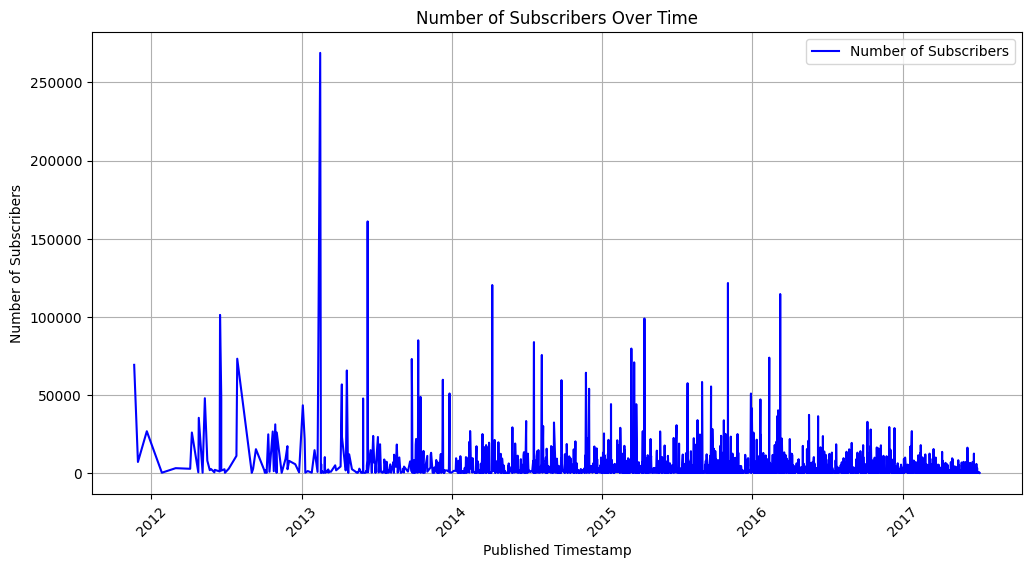

In [9]:
# Task 3: Visualize the time series data
# Converting the Spark DataFrame to a pandas DataFrame
df_pandas = df.select("published_timestamp", "num_subscribers").toPandas()

# Ordering data by timestamp to ensure the graph is generated correctly
df_pandas = df_pandas.sort_values(by="published_timestamp")

# Creating the plot with Matplotlib
plt.figure(figsize=(12, 6))
plt.plot(df_pandas["published_timestamp"], df_pandas["num_subscribers"], label="Number of Subscribers", color="blue")
plt.xlabel("Published Timestamp")
plt.ylabel("Number of Subscribers")
plt.title("Number of Subscribers Over Time")
plt.xticks(rotation=45)  # Rotates X-axis labels for better readability
plt.legend()
plt.grid()
plt.show()

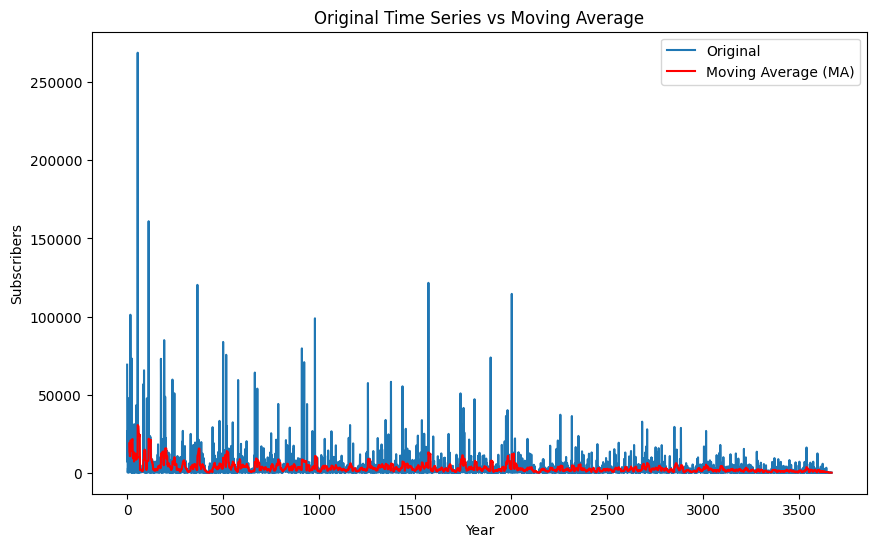

In [10]:
# Converting the Spark DataFrame to a pandas DataFrame
df_pandas = df.select("num_subscribers").toPandas()

# Define the window size for the moving average
window_size = 12  # For example, using a 12-month moving average for monthly data

# Calculate the moving average
moving_avg = df_pandas['num_subscribers'].rolling(window=window_size).mean()

# Plot the original time series and the moving average
plt.figure(figsize=(10, 6))
plt.plot(df_pandas['num_subscribers'], label='Original')
plt.plot(moving_avg, color='red', label='Moving Average (MA)')
plt.xlabel('Year')
plt.ylabel('Subscribers')
plt.title('Original Time Series vs Moving Average')
plt.legend()
plt.show()

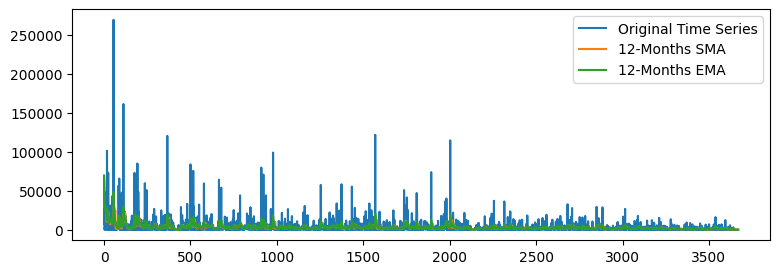

In [11]:
# Converting the Spark DataFrame to a pandas DataFrame
df_pandas = df.select("num_subscribers").toPandas()

#calculates an exponential moving average (EMA) for the original time series  with a 12 Months window.
ema_window = 12 # 12-Months moving average
ema = df_pandas.ewm(span=ema_window, adjust=False).mean()
ema


plt.figure(figsize=(9, 3))
plt.plot(df_pandas, label='Original Time Series')
plt.plot(moving_avg , label=f'{ema_window}-Months SMA')
plt.plot(ema, label=f'{ema_window}-Months EMA')
plt.legend()


In [15]:
# Converting the Spark DataFrame to a pandas DataFrame
from statsmodels.tsa.seasonal import seasonal_decompose

# Converting the Spark DataFrame to a pandas DataFrame
df_pandas = df.select("published_timestamp", "num_subscribers").toPandas()

# Converter a coluna 'published_timestamp' para datetime
df_pandas["published_timestamp"] = pd.to_datetime(df_pandas["published_timestamp"])

# Set 'published_timestamp' as index
df_pandas.set_index("published_timestamp", inplace=True)

# Ensure the index has a defined frequency (such as daily 'D', weekly 'W', etc.)
df_pandas = df_pandas.asfreq('W')  # Set daily frequency. Adjust according to your data.

# Check for missing values ​​after setting frequency
df_pandas["num_subscribers"].fillna(method="ffill", inplace=True)  # Fill missing values ​​with forward fill

# Verificar novamente se há valores ausentes
if df_pandas["num_subscribers"].isnull().sum() > 0:
    print("There are still missing values! Check the data.")
else:
    # Perform seasonal decomposition
    decomposition = seasonal_decompose(df_pandas["num_subscribers"], model='additive')

    # Plotar os componentes da decomposição
    decomposition.plot()
    plt.tight_layout()
    plt.show()

There are still missing values! Check the data.


In [16]:
df = df.withColumn("published_timestamp", current_date())

Test Set Accuracy: 0.2115
Best maxDepth: <bound method _DecisionTreeParams.getMaxDepth of RandomForestClassificationModel: uid=RandomForestClassifier_0375a5cbcc67, numTrees=10, numClasses=38, numFeatures=2>
Best numTrees: 10


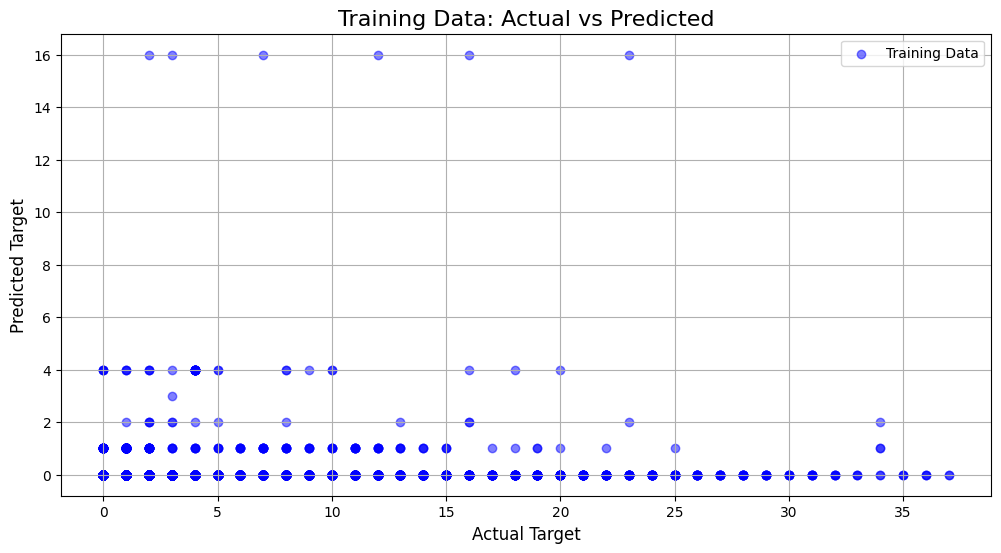

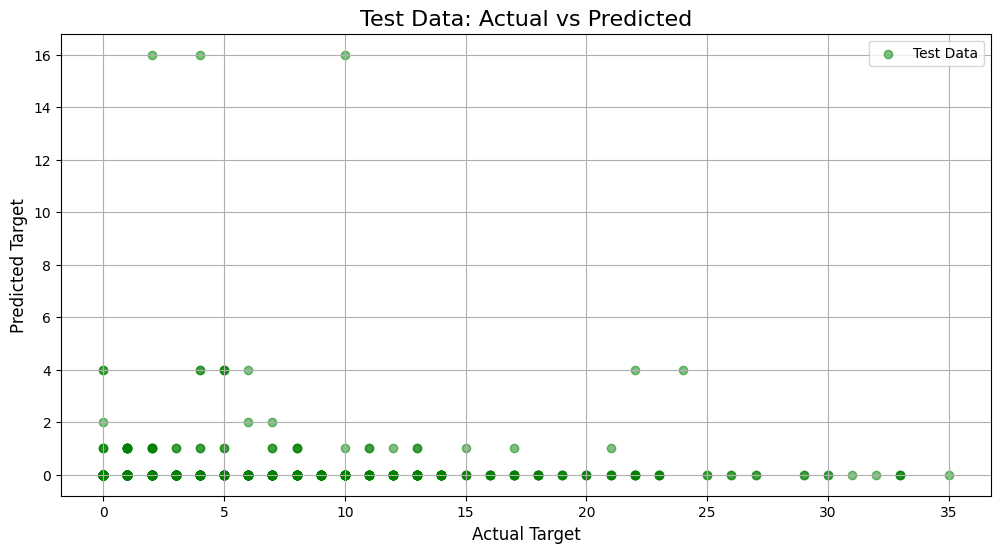

In [19]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import StringIndexer

# Prepare feature vector
feature_cols = ["lag_1", "lag_2"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Check if the "features" column already exists and remove it
if "features" in df.columns:
    df = df.drop("features")

data = assembler.transform(df)

# Index the target labels to be in [0, 100)
indexer = StringIndexer(inputCol="target", outputCol="indexed_target")
data = indexer.fit(data).transform(data)

# Drop the original 'target' column and rename 'indexed_target' to 'target'
data = data.drop("target").withColumnRenamed("indexed_target", "target")

# Split dataset into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Define the Random Forest Classifier model
rf = RandomForestClassifier(featuresCol="features", labelCol="target", seed=42)

# Set up a parameter grid for hyperparameter tuning
paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [3, 5, 7])  # Test different max depths
             .addGrid(rf.numTrees, [10, 50, 100])  # Test different numbers of trees
             .build())

# Define a classification evaluator for accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy")

# Set up cross-validation
cv = CrossValidator(estimator=rf,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=3,  # 3-fold cross-validation
                    seed=42)

# Fit the model with cross-validation
cv_model = cv.fit(train_data)

# Get the best model from cross-validation
best_model = cv_model.bestModel

# Make predictions for both training and test datasets
train_predictions = best_model.transform(train_data)
test_predictions = best_model.transform(test_data)

# Evaluate the best model on the test set
accuracy = evaluator.evaluate(test_predictions)
print(f"Test Set Accuracy: {accuracy:.4f}")

# Print the best hyperparameters
print(f"Best maxDepth: {best_model.getMaxDepth}")
print(f"Best numTrees: {best_model.getNumTrees}")

# Convert predictions to Pandas DataFrame for visualization
train_predictions_pd = train_predictions.select("target", "prediction").toPandas()
test_predictions_pd = test_predictions.select("target", "prediction").toPandas()

# Plot scatter plot for training data
plt.figure(figsize=(12, 6))
plt.scatter(train_predictions_pd["target"], train_predictions_pd["prediction"], alpha=0.5, label="Training Data", color="blue")
plt.title("Training Data: Actual vs Predicted", fontsize=16)
plt.xlabel("Actual Target", fontsize=12)
plt.ylabel("Predicted Target", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Plot scatter plot for test data
plt.figure(figsize=(12, 6))
plt.scatter(test_predictions_pd["target"], test_predictions_pd["prediction"], alpha=0.5, label="Test Data", color="green")
plt.title("Test Data: Actual vs Predicted", fontsize=16)
plt.xlabel("Actual Target", fontsize=12)
plt.ylabel("Predicted Target", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [20]:
df.printSchema()

root
 |-- course_id: integer (nullable = true)
 |-- course_title: string (nullable = true)
 |-- url: string (nullable = true)
 |-- is_paid: boolean (nullable = true)
 |-- price: integer (nullable = true)
 |-- num_subscribers: integer (nullable = true)
 |-- num_reviews: integer (nullable = true)
 |-- num_lectures: integer (nullable = true)
 |-- level: string (nullable = true)
 |-- content_duration: string (nullable = true)
 |-- published_timestamp: date (nullable = false)
 |-- subject: string (nullable = true)
 |-- subject_indexed_1: double (nullable = false)
 |-- timestamp: timestamp (nullable = true)
 |-- target: integer (nullable = true)
 |-- lag_1: integer (nullable = true)
 |-- lag_2: integer (nullable = true)



In [21]:
from pyspark.sql.functions import when

df = df.withColumn(
    "num_subscribers",
    when(col("target") < 15, 0)
    .when(col("target") < 25, 1)
    .otherwise(2)
)

In [22]:
df = df.withColumn("target", col("price"))

In [23]:
from pyspark.sql.functions import col, regexp_extract
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Content_duration column conversion
df = df.withColumn("content_duration", col("content_duration").cast("float"))

# If I need to extract numbers from more complex strings:
# df = df.withColumn("content_duration", regexp_extract(col("content_duration"), r"(\d+\.?\d*)", 1).cast("float"))

# Check the schema
df.printSchema()

# Create features
feature_cols = ["num_reviews", "num_lectures", "content_duration"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(df)

# Splitting the dataset
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Train model
lr = LogisticRegression(featuresCol="features", labelCol="num_subscribers", maxIter=10)
model = lr.fit(train_data)

# Make predictions
predictions = model.transform(test_data)
predictions.select("features", "num_subscribers", "prediction").show()

# Evaluate model
evaluator = MulticlassClassificationEvaluator(labelCol="num_subscribers", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")



root
 |-- course_id: integer (nullable = true)
 |-- course_title: string (nullable = true)
 |-- url: string (nullable = true)
 |-- is_paid: boolean (nullable = true)
 |-- price: integer (nullable = true)
 |-- num_subscribers: integer (nullable = false)
 |-- num_reviews: integer (nullable = true)
 |-- num_lectures: integer (nullable = true)
 |-- level: string (nullable = true)
 |-- content_duration: float (nullable = true)
 |-- published_timestamp: date (nullable = false)
 |-- subject: string (nullable = true)
 |-- subject_indexed_1: double (nullable = false)
 |-- timestamp: timestamp (nullable = true)
 |-- target: integer (nullable = true)
 |-- lag_1: integer (nullable = true)
 |-- lag_2: integer (nullable = true)

+--------------------+---------------+----------+
|            features|num_subscribers|prediction|
+--------------------+---------------+----------+
| [1090.0,185.0,12.0]|              2|       2.0|
|     [60.0,67.0,7.0]|              2|       2.0|
|     [14.0,19.0,2.0]|   